In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from skimage import io, transform
import numpy as np
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
import seaborn as sns # heatmap
from datetime import datetime
from models import Classifier
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
composed = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

main_set = ImageFolder(root='simpsons_dataset', transform=composed)

In [4]:
batch_size = 500
test_size = .2

In [5]:
train_set, val_set = random_split(main_set, (len(main_set) - int(len(main_set) * test_size), int(len(main_set) * test_size)))

In [6]:
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

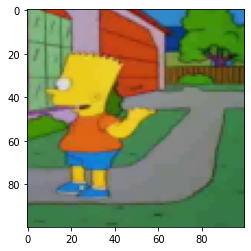

In [8]:
imshow(images[400])

In [9]:
class Classifier(nn.Module):
    def __init__(self, softmax=False):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.linear1 = nn.Linear(in_features=128 * 10 * 10, out_features=64)
        self.linear2 = nn.Linear(in_features=64, out_features=42)

        self.dropout1 = nn.Dropout(p=.25)
        self.dropout2 = nn.Dropout(p=.5)

    def forward(self, x):
        # conv 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = self.pool(x)
        x = self.dropout1(x)

        # conv 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.pool(x)
        x = self.dropout1(x)

        # conv 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.pool(x)
        x = self.dropout1(x)

        # flatten
        x = x.view(-1, 128 * 10 * 10)

        # linear 1
        x = self.linear1(x)
        x = F.relu(x)

        # linear 2 - output
        x = self.linear2(x)
        return x
#         return F.softmax(x, dim=1)

In [10]:
classifier = Classifier()

In [11]:
class Trainer(object):
    def __init__(self, model, learining_rate=.001):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=learining_rate)
        
        self.training_criterion = CrossEntropyLoss()
        self.validation_criterion = CrossEntropyLoss()
        
        self.training_loss, self.validation_loss = [], []
        
    def train(self, epochs, training_loader, training_batch_size, validation_loader=None, validation_batch_size=None, save=True):
            self.training_loss, self.validation_loss = [], []
            
            model_name = self.create_model_path()
            
            for i in range(epochs):
                training_loss = 0
                validation_loss = 0
                
                for data in train_loader:
                    images, labels = data
                    
                    self.optimizer.zero_grad()
                    
                    outputs = self.model(images)
                    
                    loss = self.training_criterion(outputs, labels)
                    
                    loss.backward()
                    self.optimizer.step()
                    
                    training_loss += loss.item()
                
                if validation_loader != None and validation_batch_size != None:
                    with torch.no_grad():
                        for data in validation_loader:
                            images, labels = data
                            
                            outputs = self.model(images)
                            
                            loss = self.validation_criterion(outputs, labels)
                        
                            validation_loss += loss.item()
                            
                self.training_loss.append(training_loss)
                self.validation_loss.append(validation_loss)
                
                if save:
                    torch.save(self.model, model_name)
                
                print("EPOCH: {}; TRAINING LOSS: {}; VALIDATION LOSS: {};".format(i+1, training_loss, validation_loss))
                    
    
    @staticmethod
    def create_model_path():
        return os.path.join('models', datetime.now().strftime("%d-%m-%Y-%H-%M-%S")) + '.pt'

In [17]:
chosen_model = 'models/04-08-2020-20-25-18.pt'

if chosen_model == '':
    trainer = Trainer(classifier)
    trainer.train(12, train_loader, batch_size, val_loader, batch_size) 
else:
    classifier = torch.load(chosen_model)
    classifier.eval()

In [18]:
if chosen_model == '':
    plt.plot(np.arange(12), trainer.training_loss, label='Training')
    plt.plot(np.arange(12), trainer.validation_loss, label='Validation')

    plt.legend()

    plt.xlabel('epocho')
    plt.ylabel('loss')

In [80]:
correct = 0
total = 0
    
conf_mat = torch.zeros([42, 42], dtype=torch.int64)
total_count_mat = torch.zeros([42, 42], dtype=torch.int64)

with torch.no_grad():
    for data in train_loader:
        images, labels = data
        
        outputs = classifier(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total = labels.shape[0]
        correct = (predicted == labels).sum().item()
        
        for i, j in enumerate(labels):
            conf_mat[j.item(), predicted[i].item()] += 1
            total_count_mat[:, j.item()] += 1
        
    print('MODEL ACCURACY ON TRAINING SET: {}%'.format(100 * correct / total))

MODEL ACCURACY ON TRAINING SET: 90.68825910931174%


In [123]:
def plot_conf_mat(conf_mat, figsize, path):
    labels_decoded = os.listdir('simpsons_dataset')
    encoder = LabelEncoder()
    encoder.fit_transform(labels_decoded)
    
    plt.figure(figsize=figsize)
    ax = sns.heatmap(conf_mat, cbar=False, yticklabels=labels_decoded, xticklabels=labels_decoded,
                     annot=True, fmt=".2f", linewidths=1)
    plt.savefig(path)
    plt.close()

In [127]:
plot_conf_mat(100 * torch.true_divide(conf_mat, total_count_mat), (25, 25), 'plots/train_conf.jpg')